In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.util import random_noise
import cv2 as cv
from os.path import join

In [3]:
data_dir = 'data/preprocessing/'

In [4]:
def show(img):
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap='gray')
    plt.show()

In [5]:
def rgb2gray(img):
    return (0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2]).astype('float32')

## Генерация

In [7]:
def noisy(image):
    row,col= image.shape
    s_vs_p = 0.5
    amount = 0.004
    
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

In [6]:
def image_generator(r,g,b,size):
    r = np.random.randint(r, r+10, size)
    g = np.random.randint(g, g+10, size)
    b = np.random.randint(b, b+10, size)
    img = np.stack((r,g,b), axis=2)
    n_lines = np.random.randint(1,5)
    for line in range(n_lines):
        width = np.random.randint(1,4)
        pos = np.random.randint(0,size[0]-width)
        img[pos:pos+width,:] = 0
    return rgb2gray(img)

In [7]:
def add_distortions(img, n=10):
    imgs = []
    for i in range(n):
        cur_img = noisy(np.copy(img))
        n_lines = np.random.randint(2,10)
        for line in range(n_lines):
            width = np.random.randint(1,2)
            pos = np.random.randint(0,cur_img.shape[1]-width)
            cur_img[:,pos:pos+width] = 0
        imgs.append(cur_img.astype('float32'))
    return np.stack(imgs)

In [8]:
def get_data(n_samples = 10, n_distortions = 10, size = (1000,1000)):
    X_train = np.empty((n_samples*n_distortions, size[0], size[1]), dtype='float32')
    y_train = np.empty((n_samples*n_distortions, size[0], size[1]), dtype='float32')

    for i in range(n_samples):
        r,g,b = np.random.randint(190,210,3)
        img = image_generator(r,g,b,size)
        y_train[i*n_distortions:(i+1)*n_distortions] = np.stack([img for i in range(n_distortions)])
        X_train[i*n_distortions:(i+1)*n_distortions] = add_distortions(img, n_distortions)

        return X_train.reshape(-1,size[0],size[1], 1), y_train

## Удаление V1

In [9]:
def delete_vertical1(img):
    if len(img.shape) != 2:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img
    # Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
    gray = cv.bitwise_not(gray)
    bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                                cv.THRESH_BINARY, 15, -2)
    # Show binary image
    # [bin]
    # [init]
    # Create the images that will use to extract the horizontal and vertical lines
    horizontal = np.copy(bw)
    vertical = np.copy(bw)
    # [init]
    # [horiz]
    # Specify size on horizontal axis
    cols = horizontal.shape[1]
    horizontal_size = int(cols / 30)
    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    # Apply morphology operations
    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)
    # Show extracted horizontal lines
    # [horiz]
    # [vert]
    # Specify size on vertical axis
    rows = vertical.shape[0]
    vertical_size = int(rows / 30)
    # Create structure element for extracting vertical lines through morphology operations
    verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))
    # Apply morphology operations
    vertical = cv.erode(vertical, verticalStructure)
    vertical = cv.dilate(vertical, verticalStructure)
    # Show extracted vertical lines
    # [vert]
    # [smooth]
    # Inverse horizontal image
    horizontal = cv.bitwise_not(horizontal)
    '''
    Extract edges and smooth image according to the logic
    1. extract edges
    2. dilate(edges)
    3. src.copyTo(smooth)
    4. blur smooth img
    5. smooth.copyTo(src, edges)
    '''
    # Step 1
    edges = cv.adaptiveThreshold(horizontal, 255, cv.ADAPTIVE_THRESH_MEAN_C, \
                                cv.THRESH_BINARY, 3, -2)
    # Step 2
    kernel = np.ones((2, 2), np.uint8)
    edges = cv.dilate(edges, kernel)
    # Step 3
    smooth = np.copy(horizontal)
    # Step 4
    smooth = cv.blur(smooth, (2, 2))
    # Step 5
    (rows, cols) = np.where(edges != 0)
    horizontal[rows, cols] = smooth[rows, cols]
    # [smooth]
    return horizontal

## Удаление V2

In [10]:
def delete_vertical2(img):
    X = np.copy(img)
    lines_idx = np.where(X.mean(axis=0) < 100)
    free_idx = np.where(X.mean(axis=0) > 100)
    for idx in lines_idx[0]:
        X[:,idx] = X[:,free_idx].mean(axis=2).ravel()
    return X

In [11]:
img_1 = cv.imread(join(data_dir, 'photo_1.jpg'), cv.IMREAD_COLOR)
img_2 = cv.imread(join(data_dir, 'photo_2.jpg'), cv.IMREAD_COLOR)
img_3 = cv.imread(join(data_dir, 'photo_3.jpg'), cv.IMREAD_COLOR)

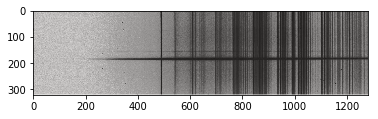

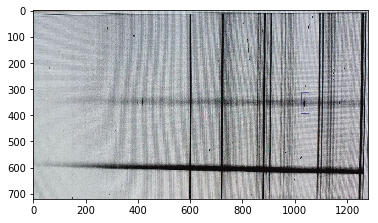

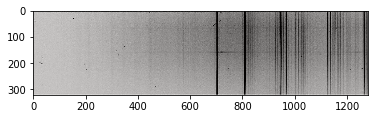

In [12]:
show(img_1)
show(img_2)
show(img_3)

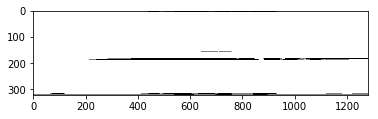

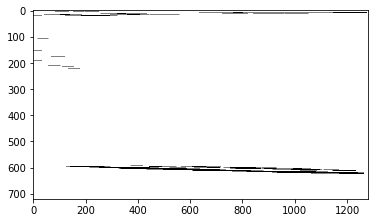

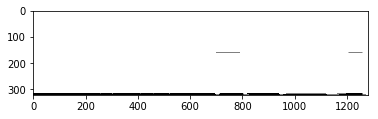

In [13]:
img = delete_vertical1(img_1)
show(img)
plt.imsave(join(data_dir, 'photo_1_v1.png'), img, cmap = plt.cm.gray)

img = delete_vertical1(img_2)
show(img)
plt.imsave(join(data_dir, 'photo_2_v1.png'), img, cmap = plt.cm.gray)

img = delete_vertical1(img_3)
show(img)
plt.imsave(join(data_dir, 'photo_3_v1.png'), img, cmap = plt.cm.gray)

In [14]:
img_1 = rgb2gray(imread(join(data_dir, 'photo_1.jpg')))
img_2 = rgb2gray(imread(join(data_dir, 'photo_2.jpg')))
img_3 = rgb2gray(imread(join(data_dir, 'photo_3.jpg')))

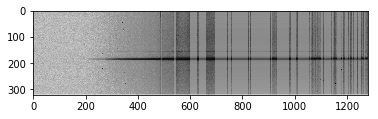

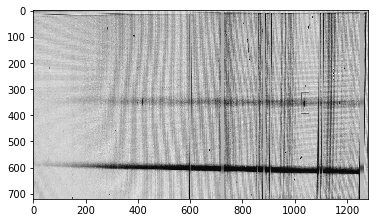

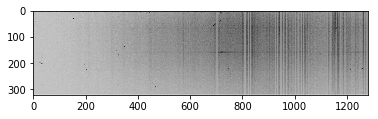

In [15]:
img = delete_vertical2(img_1)
show(img)
plt.imsave(join(data_dir, 'photo_1_v2.png'), img, cmap = plt.cm.gray)

img = delete_vertical2(img_2)
show(img)
plt.imsave(join(data_dir, 'photo_2_v2.png'), img, cmap = plt.cm.gray)

img = delete_vertical2(img_3)
show(img)
plt.imsave(join(data_dir, 'photo_3_v2.png'), img, cmap = plt.cm.gray)